# Convolutional Neural Network

Written in Julia. Require <https://github.com/MqCreaple/GNeuralNetworks.jl> to run.

In [2]:
using Plots, DataFrames, CSV
using Base.Threads

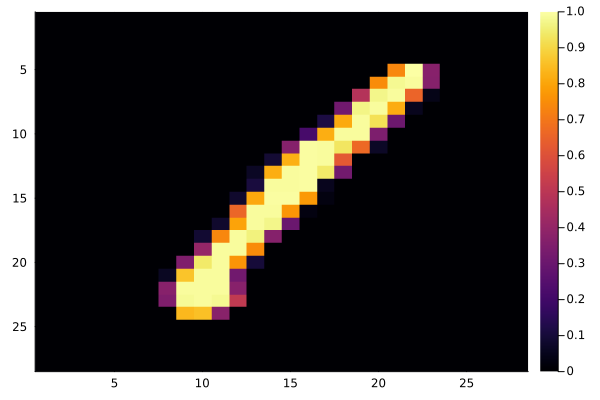

In [16]:
train = CSV.read("train.csv", DataFrame)
label = train[:, 1]
image = [collect(values(train[i, 2:end])) / 255 for i in 1:size(train)[1]]

test = CSV.read("test.csv", DataFrame)
testImage = [collect(values(test[i, :])) / 255 for i in 1:size(test)[1]]

function drawImage(img, size=(28, 28))
    return heatmap(reshape(img, size)', yflip = true)
end

drawImage(image[1])

In [4]:
using Pkg
pkg"activate C:\\Users\\gengm\\.julia\\dev\\GNeuralNetworks"
pkg"precompile GNeuralNetworks"
using GNeuralNetworks

  Activating project at `C:\Users\gengm\.julia\dev\GNeuralNetworks`


In [5]:
# Convolutionary neural network
model = Chain(
    ResizeLayer((784,), (28, 28, 1)),
    ConvLayer((28, 28), (3, 3), 1 => 3),
    MaxPoolLayer((26, 26, 3), (2, 2)),
    ConvLayer((13, 13), (4, 4), 3 => 6),
    MaxPoolLayer((10, 10, 6), (5, 5)),
    FlattenLayer(2, 2, 6),
    DenseLayer(24 => 10),
    DenseLayer(10 => 10)
)
println(model(image[1]))

[0.4475317931267283, 0.2567249400058367, 0.7097648493429207, 0.15929557774266503, 0.996266041458242, 0.36918207363160227, 0.7726779789913996, 0.12373732156950372, 0.10147268125868199, 0.1349604717377834]


In [19]:
for i in 1:18000
    index = rand(1:length(label))
    for rnd in 1:5
        p = model(image[index])
        d, _ = diff(model, mae.f_(p, onehot(10, label[index] + 1)))
        update!(model, d)
    end
end

In [26]:
for i in 1:5
    index = rand(1:length(testImage))
    savefig(drawImage(testImage[index]), "MNIST/test$i.png")
    midLayer = model.layers[2](model.layers[1](testImage[index]))
    midLayer2 = model.layers[4](model.layers[3](midLayer))
    savefig(plot(
        drawImage(midLayer[:, :, 1], (26, 26)),
        drawImage(midLayer[:, :, 2], (26, 26)),
        drawImage(midLayer[:, :, 3], (26, 26)),
        drawImage(midLayer2[:, :, 1], (10, 10)),
        drawImage(midLayer2[:, :, 2], (10, 10)),
        drawImage(midLayer2[:, :, 3], (10, 10)),
        drawImage(midLayer2[:, :, 4], (10, 10)),
        drawImage(midLayer2[:, :, 5], (10, 10)),
        drawImage(midLayer2[:, :, 6], (10, 10));
        layout=(3, 3),
        size=(700, 700)
    ), "MNIST/mid$i.png")
    savefig(bar(0:9, model(testImage[index]), xtick=0:9), "MNIST/predict$i.png")
end

In [7]:
# GAN
generator = Chain(
    Concat(IdentityLayer(10), IdentityLayer(1)),
    DenseLayer(11 => 30),
    DenseLayer(30 => 40),
    DenseLayer(40 => 784),
    ResizeLayer((784,), (28, 28))
)

discriminator = Chain(
    Concat(
        Chain(
            ResizeLayer((28, 28), (28, 28, 1)),
            ConvLayer((28, 28), (3, 3), 1 => 3),
            MaxPoolLayer((26, 26, 3), (2, 2)),
            ConvLayer((13, 13), (4, 4), 3 => 6),
            MaxPoolLayer((10, 10, 6), (5, 5)),
            FlattenLayer(2, 2, 6)
        ),
        IdentityLayer(10)
    ),
    DenseLayer(34 => 20),
    DenseLayer(20 => 1)
)

println(size(generator))
println(size(discriminator))

((10,), (1,)) => (28, 28)
((28, 28), (10,)) => (1,)


In [8]:
const judgeFalse = [0.0]
const judgeTrue = [1.0]

function trainGenerator(label::Vector{Float64}, idea::Vector{Float64})
    global generator, discriminator
    image = generator(label, idea)
    feedback = discriminator(image, label)
    _, inputDiff = diff(discriminator, cross_entropy.f_(feedback, judgeTrue))
    # println(inputDiff[1])
    gDiff, _ = diff(generator, inputDiff[1])
    update!(generator, gDiff * 0.008)
end

function trainDiscriminator(image::Matrix{Float64}, label::Vector{Float64}, expected)
    global generator, discriminator
    predict = discriminator(image, label)
    # println(cross_entropy.f_(predict, expected))
    dDiff, _ = diff(discriminator, cross_entropy.f_(predict, expected))
    update!(discriminator, dDiff * 0.01)
end

trainDiscriminator (generic function with 1 method)

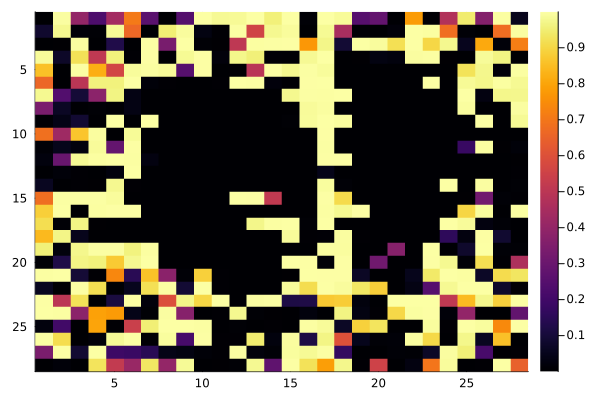

0.1681680438650417


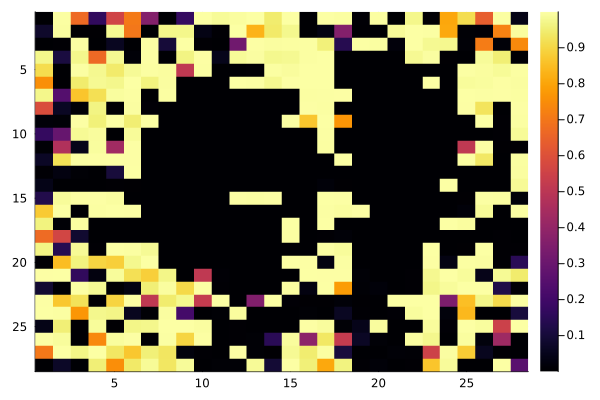

0.013579457188773921


In [15]:
genNumber = 0
img = generator(onehot(10, genNumber + 1), rand(1))
display(drawImage(img))
println(discriminator(img, onehot(10, genNumber + 1))[1])
for rnd in 1:1000
    for i in 1:5
        index = rand(eachindex(label))
        for j in 0:9
            trainDiscriminator(reshape(image[index], (28, 28)), onehot(10, j + 1),
                (j == label[index]) ? judgeTrue : judgeFalse)
        end
        for j in 1:10
            trainDiscriminator(reshape(image[index], (28, 28)), onehot(10, label[index] + 1), judgeTrue)
        end
        for j in 1:4
            generated = generator(onehot(10, label[index] + 1), rand(1))
            trainDiscriminator(generated, onehot(10, label[index] + 1), judgeFalse)
        end
    end
    for i in 1:250
        trainGenerator(onehot(10, rand(1:10)), rand(1))
    end
end
img = generator(onehot(10, genNumber + 1), rand(1))
display(drawImage(img))
println(discriminator(img, onehot(10, genNumber + 1))[1])

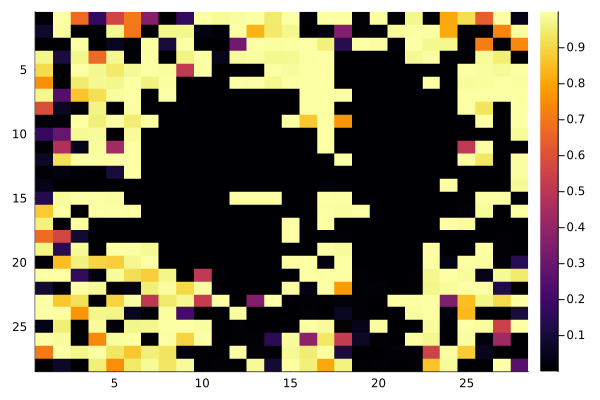

0.013580434603761031

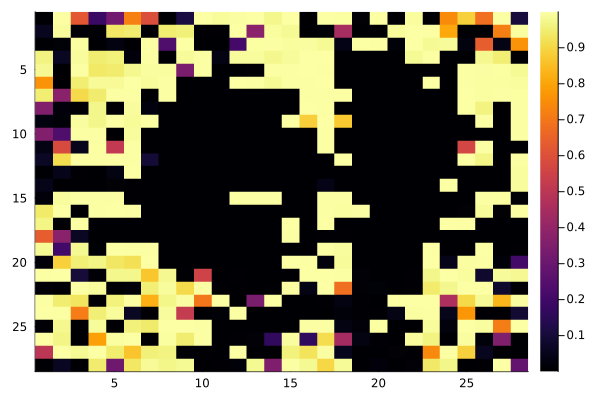

0.014427979201919239

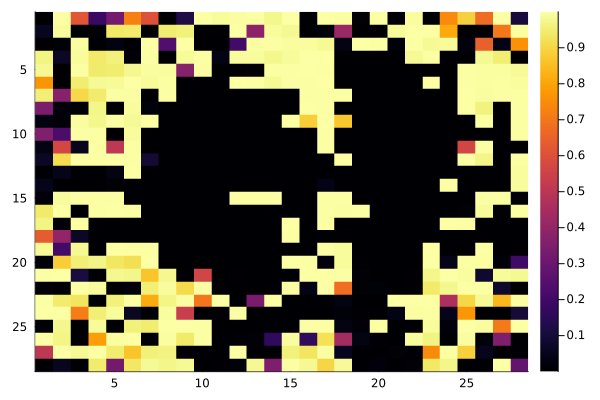

0.014386039630733354

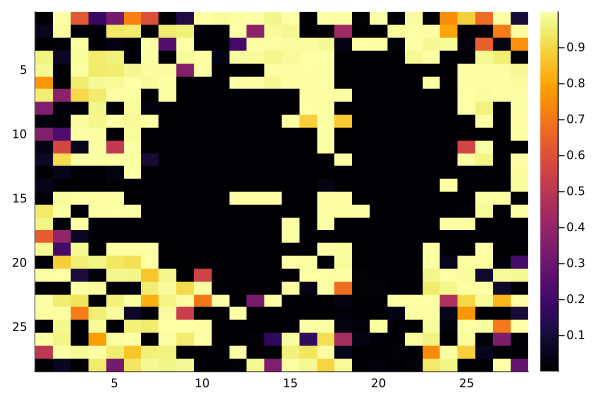

0.014415439334716715

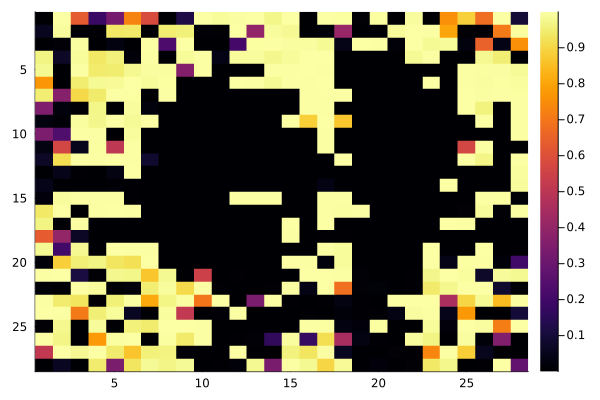

0.014256122075227733

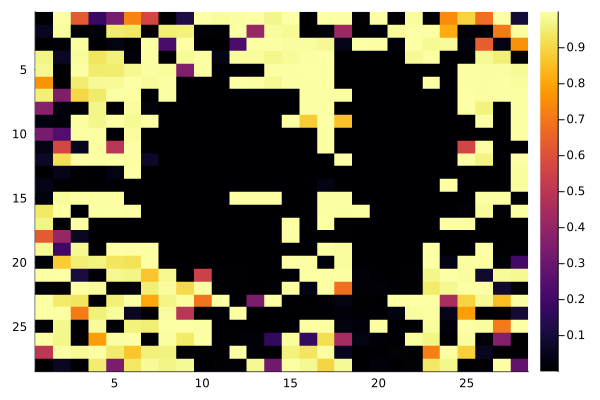

0.014109727422897563

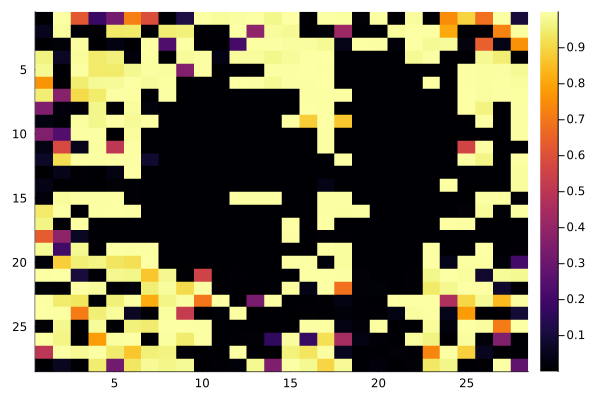

0.014298528497296842

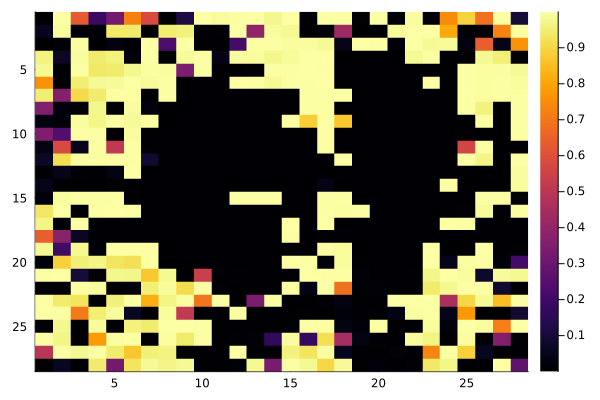

0.01431901250210159

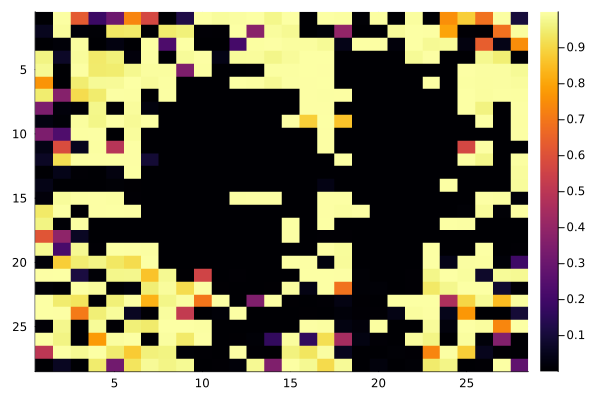

0.014414789093324056

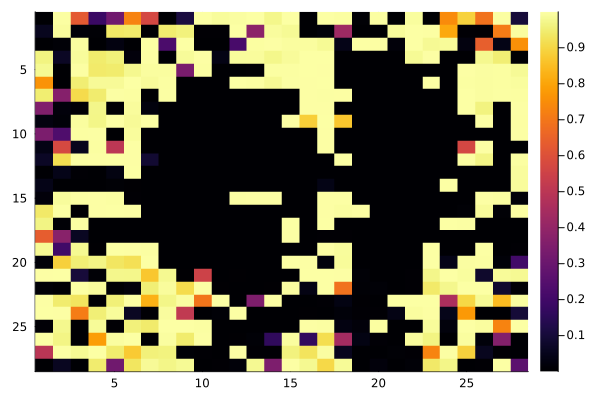

0.014327893259090046

In [18]:
for num in 1:10
    img = generator(onehot(10, num), rand(1))
    display(drawImage(img))
    display(discriminator(reshape(img, (28, 28, 1)), onehot(10, genNumber + 1))[1])
end

In [11]:
drawImage(image[2])
println(discriminator(reshape(image[2], (28, 28, 1)), onehot(10, 1)))

[0.5853160735969447]
